In [1]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import ordpy

%matplotlib inline

#extend notebook
from IPython.core.display import display, HTML
display(HTML("<style>.container {width:99.5% !important;} </style>"))


from tslearn.metrics import dtw as Dtw
# from dtaidistance import dtw
import itertools 

# Functions' definitions

In [2]:
def stdfigsize(scale=1, nrows=1, ncols=1, ratio=1.3):
    """
    Returns a tuple to be used as figure size.

    Parameters
    ----------
    returns (7*ratio*scale*nrows, 7.*scale*ncols)
    By default: ratio=1.3
    ----------
    Returns (7*ratio*scale*nrows, 7.*scale*ncols).
    """

    return((7*ratio*scale*ncols, 7.*scale*nrows))

In [3]:
#Style definitions
sns.set_style("white")
sns.set_style({"xtick.direction": "out", "ytick.direction": "out"})

rcparams = {
    'font.family': 'sans-serif',
    'font.sans-serif': ['Helvetica'],
    'axes.labelsize': 28,
    'axes.titlesize': 28,
    'legend.fontsize': 20,
    'ytick.right': 'off',
    'xtick.top': 'off',
    'ytick.left': 'on',
    'xtick.bottom': 'on',
    'xtick.labelsize': '25',
    'ytick.labelsize': '25',
    'axes.linewidth': 2.5,
    'xtick.major.width': 1.8,
    'xtick.minor.width': 1.8,
    'xtick.major.size': 14,
    'xtick.minor.size': 7,
    'xtick.major.pad': 10,
    'xtick.minor.pad': 10,
    'ytick.major.width': 1.8,
    'ytick.minor.width': 1.8,
    'ytick.major.size': 14,
    'ytick.minor.size': 7,
    'ytick.major.pad': 10,
    'ytick.minor.pad': 10,
    'axes.labelpad': 15,
    'axes.titlepad': 15,
    'axes.spines.right': False,
    'axes.spines.top': False,
    'figure.figsize': stdfigsize(),
    'lines.linewidth': 3
}
mpl.rcParams.update(rcparams)

# Disks

<p style="font-size=200px;"><b>Classification:</b></p>

1) ???

2) ???

3) Steady or periodic behavior</p>

In [4]:
disk_human_class = scipy.io.loadmat('classification/humanClassificationCircle.mat')['behaviourHuman'][0]
disk_feat_class  = scipy.io.loadmat('classification/dataCircleClassified.mat')

In [164]:
# for i, j, k in zip(mat2['dx'], mat2['dy'], range(len(mat2['dy']))):
#     if k in np.argwhere(mat2['behaviourAuto'][0]==3).flatten():
#         print('\n', i, j, k, "###############################", '\n')
#     else:
#         print('not steady', i, j)

In [5]:
#Improving data structure. Extracting data from dataCircle.mat and loading it into data arrays
disk_data = scipy.io.loadmat('classification/dataCircle.mat')

#initial condition of the experiments: 0 (dropping with arm holding the paper horizontally) or 1 (dropping 
# vertically)
disk_initcon = []
for i in range(len(disk_data['data'][0])):
    disk_initcon.append(disk_data['data'][0][i]['initialCondition'][0][0][0][0])
disk_initcon = np.asarray(disk_initcon)

# camera 1 observable area?
disk_cam1 = []
for i in range(len(disk_data['data'][0])):
    disk_cam1.append(disk_data['data'][0][i]['areaCam1'][0][0])
disk_cam1 = np.asarray(disk_cam1)

# camera 2 observable area?
disk_cam2 = []
for i in range(len(disk_data['data'][0])):
    disk_cam2.append(disk_data['data'][0][i]['areaCam2'][0][0])
disk_cam2 = np.asarray(disk_cam2)

# coordinates (x, y, z) along trajectory from 1m high to the floor.
disk_trajectory = []
for i in range(len(disk_data['data'][0])):
    disk_trajectory.append(disk_data['data'][0][i]['trajectory'][0][0])
disk_trajectory = np.asarray(disk_trajectory)

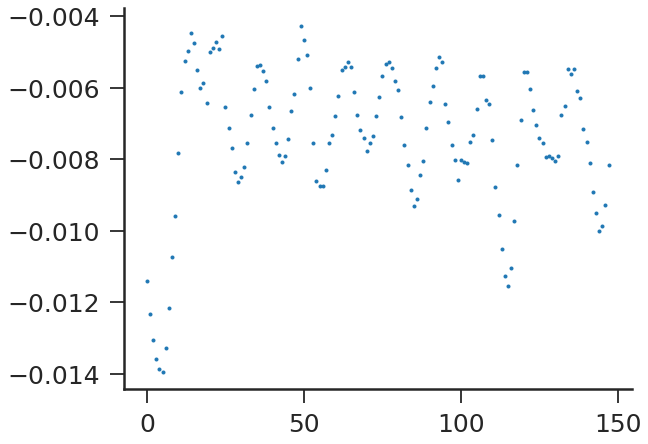

In [112]:
a = np.diff(disk_trajectory[3][::,2])

plt.plot(a, '.')

Text(0.5, 0, 'x, lateral')

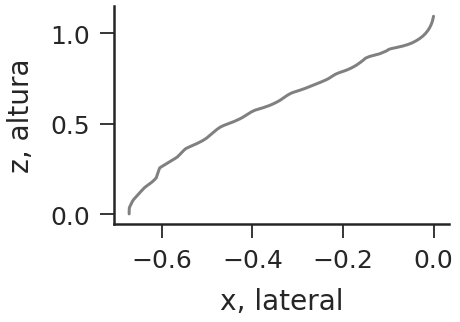

In [101]:
f, ax = plt.subplots()

i      = 21
x_, y_ = disk_trajectory[i][::,0], disk_trajectory[i][::,2]

ax.plot(x_, y_, '-', color='grey')
ax.set_ylabel('z, altura')
ax.set_xlabel('x, lateral')

In [71]:
disk_ce = []
for i in range(len(disk_trajectory)):
#     ts = np.diff(ts)
    ts = disk_trajectory[i][::]
    ts = np.sqrt(np.square(ts).sum(axis=1))
    disk_ce.append(ordpy.complexity_entropy(ts, dx=5))

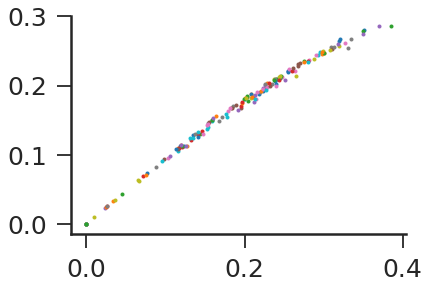

In [72]:
for h_, c_ in disk_ce:
    plt.plot(h_,c_, '.')

In [69]:
# 21seconds to run.
dtw_matrix = []
A = range(disk_trajectory.__len__())

for i,j in list(itertools.product(A, A)):
    ts1 = disk_trajectory[i]
    ts2 = disk_trajectory[j]
    dtw_matrix.append(Dtw(ts1, ts2))

In [79]:
from scipy.cluster.hierarchy import average as ClusAvg
from scipy.spatial.distance import pdist as Pdist
from scipy.cluster.hierarchy import fcluster as Fcluster

In [71]:
dtw_matrix_shape = np.reshape(dtw_matrix, (170,-1))

In [76]:
y = Pdist(dtw_matrix_shape)

In [77]:
Z = ClusAvg(y)

In [84]:
Fcluster(Z, t=40, criterion='distance')

array([1, 2, 3, 2, 2, 2, 2, 2, 3, 2, 2, 3, 2, 3, 3, 2, 3, 3, 3, 3, 3, 2,
       1, 3, 3, 3, 3, 2, 2, 2, 3, 2, 3, 2, 3, 3, 2, 2, 3, 3, 2, 2, 1, 2,
       2, 3, 3, 3, 2, 3, 3, 2, 3, 3, 3, 3, 2, 3, 3, 2, 3, 3, 3, 3, 3, 2,
       2, 2, 2, 2, 3, 2, 2, 1, 3, 2, 1, 3, 2, 3, 2, 3, 2, 3, 3, 2, 3, 3,
       2, 3, 3, 3, 3, 3, 3, 2, 2, 2, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 2, 3,
       1, 1, 3, 3, 2, 3, 3, 2, 2, 3, 1, 3, 2, 3, 3, 3, 2, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 2, 3, 1, 3, 2, 2, 2, 2, 3, 2, 3,
       2, 2, 3, 3, 2, 2, 3, 2, 2, 1, 2, 2, 2, 3, 3, 3], dtype=int32)

Falta dar um jeito de ler o código do cara e entender o critério dele pra separar um trajetória em duas, no caso, em uma parcela de
trajetória estacionária (periódica) e outro tipo (caótica ou "tumbling").

In [150]:
mat = scipy.io.loadmat('classification/Field1997_data.mat')

In [165]:
mat

{'__header__': b'MATLAB 5.0 MAT-file, Platform: MACI64, Created on: Wed Jun 12 09:44:01 2019',
 '__version__': '1.0',
 '__globals__': [],
 'c': array([[2.38277644e+01, 3.89184311e-03, 1.00000000e+00],
        [3.36187395e+01, 3.89184311e-03, 1.00000000e+00],
        [2.40504822e+01, 4.83471860e-03, 1.00000000e+00],
        [3.62164057e+01, 4.83471860e-03, 1.00000000e+00],
        [3.65549199e+01, 5.12939850e-03, 1.00000000e+00],
        [4.12545834e+01, 5.38863962e-03, 1.00000000e+00],
        [4.69936378e+01, 5.23156373e-03, 1.00000000e+00],
        [7.20944119e+01, 3.89184311e-03, 1.00000000e+00],
        [6.63036129e+01, 4.60212597e-03, 1.00000000e+00],
        [7.20944119e+01, 4.97987935e-03, 1.00000000e+00],
        [7.34484412e+01, 5.49596830e-03, 1.00000000e+00],
        [5.92995386e+01, 5.44203937e-03, 1.00000000e+00],
        [6.88175415e+01, 5.33576384e-03, 1.00000000e+00],
        [2.71425194e+01, 6.56341608e-03, 1.00000000e+00],
        [4.08725483e+01, 6.62845751e-03, 1.00

# Hexagons

# Squares

# Crosses